In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



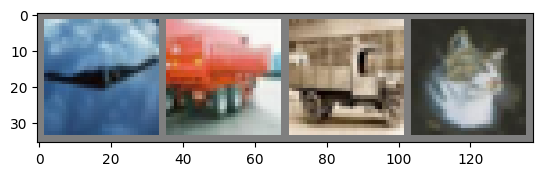

plane truck truck cat  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).

Changes made - slightly larger network so that we can prune it

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 250)  # 250 instead of 120
        self.fc2 = nn.Linear(250, 200)  # 200 instead of 84
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 2.5 We create a class to handle pruning the network

During training we monitor the mean and variance, and every few minibatches we prune the network neurons that have low variance.

In [6]:
# https://www.johndcook.com/blog/standard_deviation/

class RunningStat:

    def __init__(self):
        self.m_n = 0

    def clear(self):
        self.m_n = 0

    def push(self, x):
        self.m_n += 1
        x = x.detach().clone()
        x.requires_grad = False
        if self.m_n == 1:
            self.m_oldM = self.m_newM = x + 0
            self.m_oldS = x * 0
            self.m_newS = x * 0
        else:
            self.m_newM = self.m_oldM + (x - self.m_oldM) / self.m_n
            self.m_newS = self.m_oldS + (x - self.m_oldM) * (x - self.m_newM)
            self.m_oldM = self.m_newM
            self.m_oldS = self.m_newS

    def num_data_values(self):
        return self.m_n

    def mean(self):
        return self.m_newM if self.m_n > 0 else 0.0

    def variance(self):
        return self.m_newS / (self.m_n - 1) if self.m_n > 1 else 0.0

    def standard_deviation(self):
        return self.variance() ** 0.5

    def reshape(self, newshape):
      self.m_oldS = self.m_oldS[newshape]
      self.m_oldM = self.m_oldM[newshape]
      self.m_newS = self.m_newS[newshape]
      self.m_newM = self.m_newM[newshape]

from functools import wraps
import numpy as np

class linear_pruner:

    def __init__(self, layerprev, layernext, activation=lambda x: x, model_and_optimizer = None):
        self.layerprev = layerprev
        self.layernext = layernext
        self.old_layerprev_forward = layerprev.forward
        self.activation = activation
        self.model_and_optimizer = model_and_optimizer # for momentum
        self.stats = RunningStat()

    def hook(self):
        @wraps(self.old_layerprev_forward)
        def new_layerprev_forward_observe(*_, **__):
            x = self.old_layerprev_forward(*_, **__)
            if len(x.shape) == 1:
                self.stats.push(x)
            elif len(x.shape) == 2:
                for i in x:
                    self.stats.push(i)
            else:
                raise NotImplementedError(f"Cannot override forward pass for input shape {x.shape}")
            return x
        self.layerprev.forward = new_layerprev_forward_observe

    def unhook(self):
        self.layerprev.forward = self.old_layerprev_forward

    def test_prune(self, threshold_mean_fraction: float = 0.6, threshold_percentile: int = 0):
        # Threshold of what needs pruning
        assert (threshold_mean_fraction >= 0) and (100 >threshold_percentile >= 0), "Need valid_vaues"
        if threshold_mean_fraction > 0:
            threshold = torch.mean(self.stats.standard_deviation())*threshold_mean_fraction
        else:
            threshold = np.percentile(np.array(self.stats.standard_deviation().detach().clone().cpu()), threshold_percentile)
        bad_locations = torch.where(self.stats.standard_deviation() < threshold)[0]
        meanreplacement = self.activation(self.stats.mean()[bad_locations])
        @wraps(self.old_layerprev_forward)
        def new_layerprev_forward_test(*_, **__):
            x = self.old_layerprev_forward(*_, **__)
            if len(x.shape) == 1:
               x[bad_locations] = meanreplacement
            elif len(x.shape) == 2:
               x[:, bad_locations] = meanreplacement
            else:
                raise NotImplementedError(f"Cannot override forward pass for input shape {x.shape}")
            return x
        self.layerprev.forward = new_layerprev_forward_test

    def permanent_prune(self, threshold_mean_fraction: float = 0.6, threshold_percentile: int = 0):
        # Threshold of what needs pruning
        assert (threshold_mean_fraction >= 0) and (100 >threshold_percentile >= 0), "Need valid_vaues"
        if threshold_mean_fraction > 0:
            threshold = torch.mean(self.stats.standard_deviation())*threshold_mean_fraction
        else:
            threshold = np.percentile(np.array(self.stats.standard_deviation().detach().clone().cpu()), threshold_percentile)
        # Get pruning locations
        bad_locations = torch.where(self.stats.standard_deviation() < threshold)[0]
        good_locations = torch.where(self.stats.standard_deviation() >= threshold)[0]

        if self.model_and_optimizer:
            state_dict = self.model_and_optimizer[1].state_dict()['state']
        # Prune layerprev and state
        if self.model_and_optimizer:
            index = next(i for i, p in enumerate(self.model_and_optimizer[0].parameters()) if p is self.layerprev.weight)
            state_dict[index]["momentum_buffer"].data = state_dict[index]["momentum_buffer"].data[good_locations, :]
        self.layerprev.weight.data = self.layerprev.weight.data[good_locations, :]
        if self.model_and_optimizer:
            index = next(i for i, p in enumerate(self.model_and_optimizer[0].parameters()) if p is self.layerprev.bias)
            state_dict[index]["momentum_buffer"].data = state_dict[index]["momentum_buffer"].data[good_locations]

        self.layerprev.bias.data = self.layerprev.bias.data[good_locations]
        self.layerprev.out_features = len(good_locations)

        # Prune layerprev grad
        if self.layerprev.weight.grad is not None:
            self.layerprev.weight.grad.data = self.layerprev.weight.grad.data[good_locations, :]
        if self.layerprev.bias.grad is not None:
            self.layerprev.bias.grad.data = self.layerprev.bias.grad.data[good_locations]

        # Edit layernext bias data
        temp_bias = self.layernext.bias.data + 0
        self.layernext.bias.data = temp_bias * 0
        dummy = torch.zeros(self.layernext.weight.data.shape[1], device=self.layernext.weight.data.device)
        dummy[bad_locations] = self.stats.mean()[bad_locations]
        dummy = self.activation(dummy)
        bias_edit = self.layernext.forward(dummy)
        self.layernext.bias.data = temp_bias + bias_edit

        # Prune layernext weight
        if self.model_and_optimizer:
            index = next(i for i, p in enumerate(self.model_and_optimizer[0].parameters()) if p is self.layernext.weight)
            state_dict[index]["momentum_buffer"].data = state_dict[index]["momentum_buffer"].data[:, good_locations]
        self.layernext.weight.data = self.layernext.weight.data[:, good_locations]
        self.layernext.in_features = len(good_locations)
        # Prune layernext grad
        if self.layernext.weight.grad is not None:
            self.layernext.weight.grad.data = self.layernext.weight.grad.data[:, good_locations]
        # reshape stats
        self.stats.reshape(good_locations)
        # Remake parameters
        self.layerprev.weight = nn.Parameter(self.layerprev.weight)
        self.layerprev.bias = nn.Parameter(self.layerprev.bias)
        self.layernext.weight = nn.Parameter(self.layernext.weight)

        #Force update optimizer params
        if self.model_and_optimizer:
            new_state = dict(zip(self.model_and_optimizer[0].parameters(), self.model_and_optimizer[1].state.values()))
            self.model_and_optimizer[1].state.clear()
            self.model_and_optimizer[1].state.update(new_state)
            self.model_and_optimizer[1].param_groups[0]['params'] = list(self.model_and_optimizer[0].parameters())

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 3.5. Hook into the network and define the layers we want to use.

Using the custom linear_pruner class

In [8]:
pruner1 = linear_pruner(net.fc1, net.fc2, F.relu, (net, optimizer))
pruner2 = linear_pruner(net.fc2, net.fc3, F.relu, (net, optimizer))
pruner1.hook()
pruner2.hook()

### 4. Train the network

This is when things start to get very interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.
And on every mini batch we prune the network



In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            # Pruning
            pruner1.permanent_prune()
            pruner2.permanent_prune()

# We can then unhook from the model
pruner1.unhook()
pruner2.unhook()
print('Finished Training')

[1,  2000] loss: 2.169
[1,  4000] loss: 1.773
[1,  6000] loss: 1.632
[1,  8000] loss: 1.528
[1, 10000] loss: 1.491
[1, 12000] loss: 1.433
[2,  2000] loss: 1.343
[2,  4000] loss: 1.337
[2,  6000] loss: 1.291
[2,  8000] loss: 1.284
[2, 10000] loss: 1.236
[2, 12000] loss: 1.226
Finished Training


let's see what our new model looks like

In [10]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=181, bias=True)
  (fc2): Linear(in_features=181, out_features=107, bias=True)
  (fc3): Linear(in_features=107, out_features=10, bias=True)
)


That definitely worked - our architecture has changed
Let's quickly save our trained model:



In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



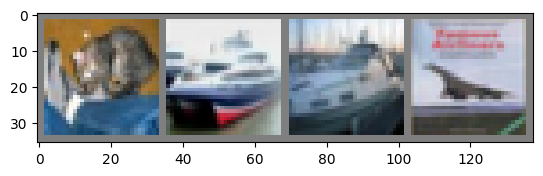

GroundTruth:  cat   ship  ship  plane


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's see what happense when we try to load back in our saved model (note: this breaks because of pruning)



In [13]:
import traceback
try:
    net_loaded = Net()
    net_loaded.load_state_dict(torch.load(PATH))
except RuntimeError:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "<ipython-input-13-4ced9f71ea99>", line 4, in <cell line: 2>
    net_loaded.load_state_dict(torch.load(PATH))
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 2152, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for fc1.weight: copying a param with shape torch.Size([181, 400]) from checkpoint, the shape in current model is torch.Size([250, 400]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([181]) from checkpoint, the shape in current model is torch.Size([250]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([107, 181]) from checkpoint, the shape in current model is torch.Size([200, 250]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([107]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for fc3.we

Okay, now let us see what the neural network thinks these examples above are:



In [14]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.1 %
Accuracy for class: car   is 75.9 %
Accuracy for class: bird  is 39.7 %
Accuracy for class: cat   is 39.5 %
Accuracy for class: deer  is 49.0 %
Accuracy for class: dog   is 38.3 %
Accuracy for class: frog  is 68.1 %
Accuracy for class: horse is 68.7 %
Accuracy for class: ship  is 70.0 %
Accuracy for class: truck is 75.3 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [19]:
del dataiter